<a href="https://colab.research.google.com/github/StephenJohnson-CardiffUni/Astro/blob/main/CondensedAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import scipy.constants as consts
import scipy.integrate
from scipy.optimize import curve_fit as curveFit

<ipython-input-2-f42af91bc043>:24: RuntimeWarning: overflow encountered in power
  numerator   = ((Etemp/tempratures)**2) * (np.e**(Etemp/tempratures))
<ipython-input-2-f42af91bc043>:24: RuntimeWarning: overflow encountered in multiply
  numerator   = ((Etemp/tempratures)**2) * (np.e**(Etemp/tempratures))
<ipython-input-2-f42af91bc043>:25: RuntimeWarning: overflow encountered in power
  denominator = ((np.e**(Etemp/tempratures)) - 1)
<ipython-input-2-f42af91bc043>:26: RuntimeWarning: overflow encountered in square
  return (3 * R) * ( numerator / denominator**2)
<ipython-input-2-f42af91bc043>:26: RuntimeWarning: invalid value encountered in true_divide
  return (3 * R) * ( numerator / denominator**2)


Text(0.5, 1.0, 'Einstein Model Fails T^3 at low Temperatures')

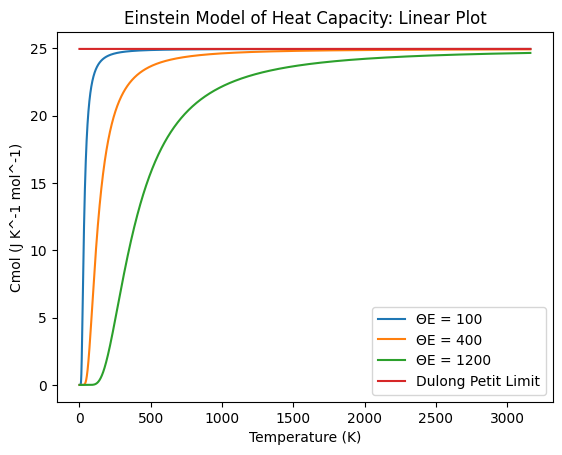

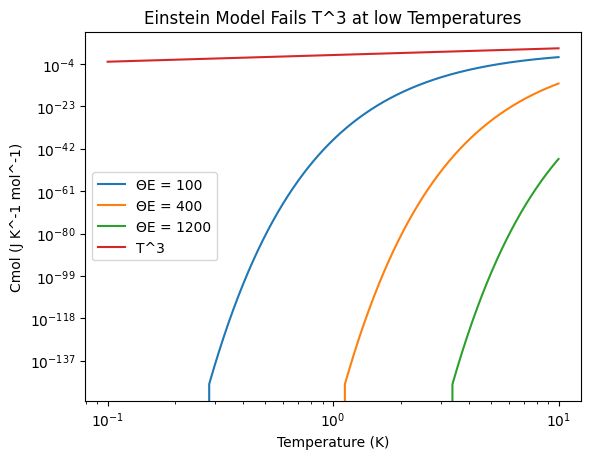

In [2]:
'''a)Plot the predicted curves for the Einstein model for ΘE = 100 K, 400 K, and 1200 K on a graph with linear axes,
showing the Dulong-Petit limit

Re-plot the curves on a graph with logarithmic axes to show that the Einstein
model does not reproduce the the expected T**3 proportionality
'''

#define some constants
R = 8.314462618
DulongPetitLimit = 3 * R

#various temperature ranges
temperatures = np.array([x for x in range(1,2500)])
temperaturesLogSpread = np.logspace(-2, 3.5, 2500)
temperaturesLowLogSpread = np.logspace(-1, 1, 2500)

#function
def EinsteinCaps(tempratures,Etemp):
  '''
  Takes tempterature range and einstein Temp.
  returns heat capacities at the tempratures in range
  Uses Einstein Model : Cmol(T) = 3R ( ((ΘE/T)**2) * (e**(ΘE/T)) /  ((e**(ΘE/T)) − 1)**2 ) 
  '''
  numerator   = ((Etemp/tempratures)**2) * (np.e**(Etemp/tempratures))
  denominator = ((np.e**(Etemp/tempratures)) - 1)
  return (3 * R) * ( numerator / denominator**2)


#Linear plots
plt.plot(temperaturesLogSpread,EinsteinCaps(temperaturesLogSpread,100 ),label="ΘE = 100")
plt.plot(temperaturesLogSpread,EinsteinCaps(temperaturesLogSpread,400 ),label="ΘE = 400")
plt.plot(temperaturesLogSpread,EinsteinCaps(temperaturesLogSpread,1200),label="ΘE = 1200")
plt.plot(temperaturesLogSpread,list(DulongPetitLimit for x in range(len(temperaturesLogSpread))),label="Dulong Petit Limit")
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.legend()
plt.title("Einstein Model of Heat Capacity: Linear Plot")

#loglog plots
plt.figure()
plt.loglog(temperaturesLowLogSpread,EinsteinCaps(temperaturesLowLogSpread,100 ),label="ΘE = 100")
plt.loglog(temperaturesLowLogSpread,EinsteinCaps(temperaturesLowLogSpread,400 ),label="ΘE = 400")
plt.loglog(temperaturesLowLogSpread,EinsteinCaps(temperaturesLowLogSpread,1200),label="ΘE = 1200")
plt.loglog(temperaturesLowLogSpread,temperaturesLowLogSpread**3,label="T^3")
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.legend()
plt.title("Einstein Model Fails T^3 at low Temperatures")

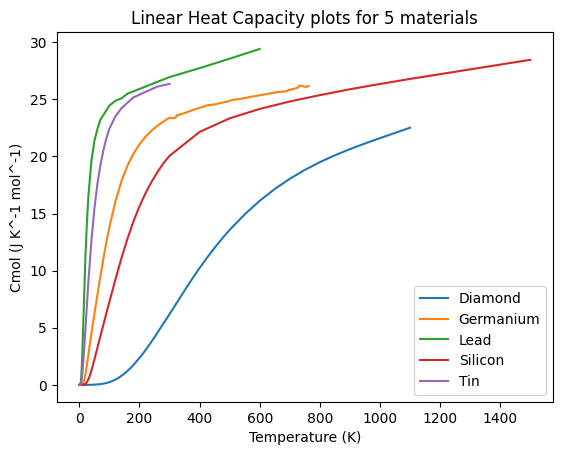

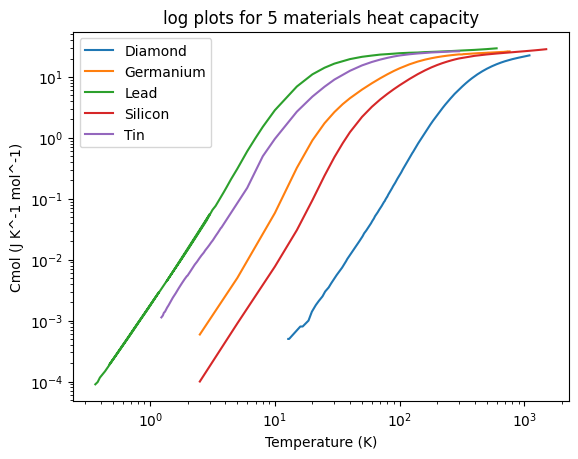

In [3]:
'''

b) Plot the combined data sets for the five materials on two separate graphs

'''



def load_data(file_paths):
    data = {}
    for file_path in file_paths:
        column1 = []
        column2 = []
        column1,column2 = np.loadtxt(file_path,unpack=True)
        data[file_path] = (column1, column2)
    return data

#pass in file locations and load columns into dictionary
file_paths = ['/content/diamond.txt', '/content/germanium.txt', '/content/lead_v3.txt','/content/silicon.txt','/content/tin.txt']
data = load_data(file_paths)

# Access the columns for a specific file path
diamondTemperature, diamondHeatCapacity = data['/content/diamond.txt']
germaniumTemperature, germaniumHeatCapacity = data['/content/germanium.txt']
leadTemperature, leadHeatCapacity = data['/content/lead_v3.txt']
siliconTemperature, siliconHeatCapacity = data['/content/silicon.txt']
tinTemperature, tinHeatCapacity = data['/content/tin.txt']


#linear Plots
plt.plot(diamondTemperature,diamondHeatCapacity,label="Diamond")
plt.plot(germaniumTemperature,germaniumHeatCapacity,label="Germanium")
plt.plot(leadTemperature,leadHeatCapacity,label="Lead")
plt.plot(siliconTemperature,siliconHeatCapacity,label="Silicon")
plt.plot(tinTemperature,tinHeatCapacity,label="Tin")
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.title("Linear Heat Capacity plots for 5 materials")
plt.legend()

#loglog plot
plt.figure()
plt.loglog(diamondTemperature,diamondHeatCapacity,label="Diamond")
plt.loglog(germaniumTemperature,germaniumHeatCapacity,label="Germanium")
plt.loglog(leadTemperature,leadHeatCapacity,label="Lead")
plt.loglog(siliconTemperature,siliconHeatCapacity,label="Silicon")
plt.loglog(tinTemperature,tinHeatCapacity,label="Tin")
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.title("log plots for 5 materials heat capacity")
plt.legend()

In [4]:
'''

c) We have shown in the lecture notes that the Debye model produces the correct T**3 proportionality for the molar
heat capacity at low temperature. By fitting the experimental data for diamond, silicon, germanium, tin, and lead
at low temperature, calculate the Debye temperature ΘD for the five materials. Show your fits on five separate
plots with double logarithmic axes, as demonstrated on the left of figure 1

'''

#finction for curvefit and then function for that function

def debye(T,D):
  x = (D/T).all()
  integral, _ = scipy.integrate.quad(integrand,0,x) #Dummy variable saves us having to deal with 2d list

  return (9*R) * ((T/D)**3) * integral

def integrand(x):
  return ((x**4)*(np.e**x)) / (((np.e**x)-1)**2)



'''stolen from yuri'''

def debye_integral(x):
    return (x ** 4 * np.exp(x)) / ((np.exp(x) - 1) ** 2)

def cmol(T, ΘD, R=8.314):
    limit = (ΘD / T).all()
    integral, _ = scipy.integrate.quad(debye_integral, 0, limit)
    cmol_T = 9 * R * ((T / ΘD) ** 3) * integral

    return cmol_T

# plt.loglog(temperatures,debye(temperatures,list(105 for x in range(len(temperatures)))))
# plt.figure()
# plt.loglog(temperatures,cmol(temperatures,list(105 for x in range(len(temperatures)))))

'''they both give the same values and his works so mine should be fine..... '''


#limit data range to linear section
diamondLowTemperature = diamondTemperature[diamondHeatCapacity<1]
diamondLowHeatCapacity = diamondHeatCapacity[diamondHeatCapacity<1]
germaniumLowTemperature = germaniumTemperature[germaniumHeatCapacity<1]
germaniumLowHeatCapacity = germaniumHeatCapacity[germaniumHeatCapacity<1]
leadLowTemperature = leadTemperature[leadHeatCapacity<1]
leadLowHeatCapacity = leadHeatCapacity[leadHeatCapacity<1]
siliconLowTemperature = siliconTemperature[siliconHeatCapacity<1]
siliconLowHeatCapacity = siliconHeatCapacity[siliconHeatCapacity<1]
tinLowTemperature = tinTemperature[tinHeatCapacity<1]
tinLowHeatCapacity = tinHeatCapacity[tinHeatCapacity<1]



#curvefits for all the metals, lets find D for all
poptLowDiamond,pcovLowDiamond = curveFit(debye,diamondLowTemperature,diamondLowHeatCapacity)
poptLowGermanium,pcovLowGermanium = curveFit(debye,germaniumLowTemperature,germaniumLowHeatCapacity)
poptLowLead,pcovLowLead = curveFit(debye,leadLowTemperature,leadLowHeatCapacity)
poptLowSilicon,pcovLowSilicon = curveFit(debye,siliconLowTemperature,siliconLowHeatCapacity)
poptLowTin,pcovLowTin = curveFit(debye,tinLowTemperature,tinLowHeatCapacity)

[441.34494683]


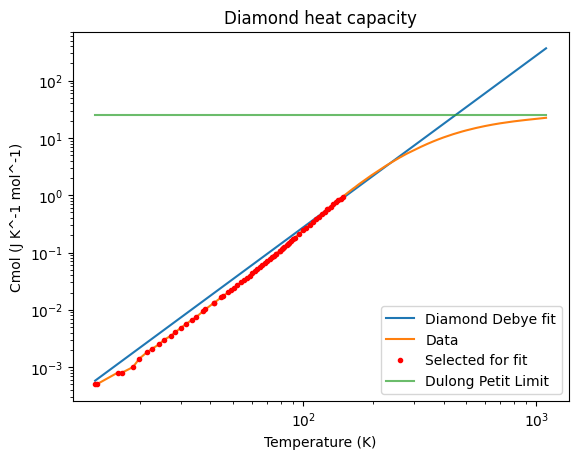

In [5]:
'''Each plot requires a fit plot extended to the bounds, A data plot, DulongPetit, Points used for fit highlighted'''

#Fit plots
plt.loglog(diamondTemperature,debye(diamondTemperature,poptLowDiamond),label="Diamond Debye fit")
plt.loglog(diamondTemperature,diamondHeatCapacity,label="Data")
plt.loglog(diamondLowTemperature,diamondLowHeatCapacity, ".r",label = "Selected for fit")
plt.loglog(diamondTemperature,list(DulongPetitLimit for x in range(len(diamondTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.title("Diamond heat capacity")
plt.legend()
print(poptLowDiamond)

<ipython-input-6-ea11574302aa>:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,1000)


[59.94840324]


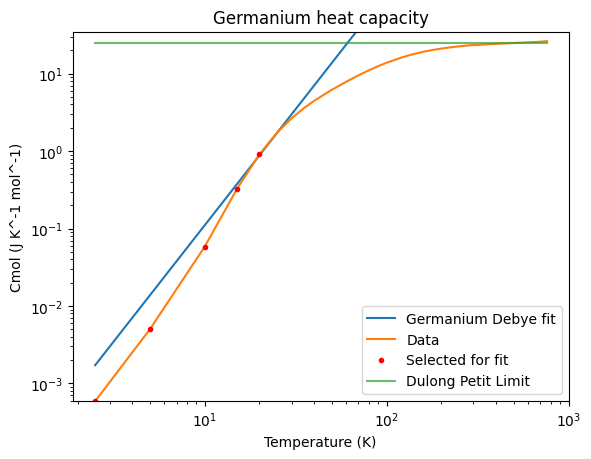

In [6]:
plt.loglog(germaniumTemperature,debye(germaniumTemperature,poptLowGermanium),label="Germanium Debye fit")
plt.loglog(germaniumTemperature,germaniumHeatCapacity,label="Data")
plt.loglog(germaniumLowTemperature,germaniumLowHeatCapacity, ".r",label = "Selected for fit")
plt.loglog(germaniumTemperature,list(DulongPetitLimit for x in range(len(germaniumTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlim(0,1000)
plt.ylim(germaniumHeatCapacity[0],DulongPetitLimit+10)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.title("Germanium heat capacity")
plt.legend()

print(poptLowGermanium)

<ipython-input-7-ceaadbee2a29>:8: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,200)


[20.48806703]


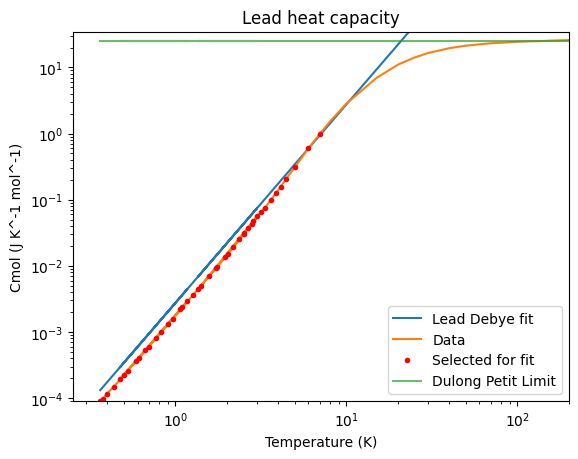

In [7]:
plt.loglog(leadTemperature,debye(leadTemperature,poptLowLead),label="Lead Debye fit")
plt.loglog(leadTemperature,leadHeatCapacity,label="Data")
plt.loglog(leadLowTemperature,leadLowHeatCapacity, ".r",label = "Selected for fit")
plt.loglog(leadTemperature,list(DulongPetitLimit for x in range(len(leadTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.title("Lead heat capacity")
plt.xlim(0,200)
plt.ylim(leadHeatCapacity[0],DulongPetitLimit+10)
plt.legend()
print(poptLowLead)

<ipython-input-8-4edbb015fa88>:8: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,200)


[109.27337115]


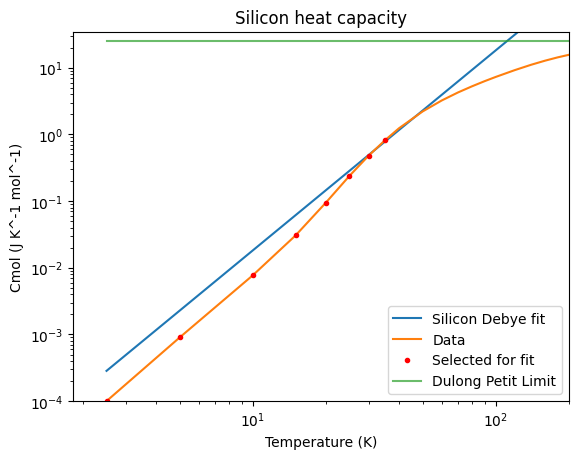

In [8]:
plt.loglog(siliconTemperature,debye(siliconTemperature,poptLowSilicon),label="Silicon Debye fit")
plt.loglog(siliconTemperature,siliconHeatCapacity,label="Data")
plt.loglog(siliconLowTemperature,siliconLowHeatCapacity, ".r",label = "Selected for fit")
plt.loglog(siliconTemperature,list(DulongPetitLimit for x in range(len(siliconTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.title("Silicon heat capacity")
plt.xlim(0,200)
plt.ylim(siliconHeatCapacity[0],DulongPetitLimit+10)
plt.legend()
print(poptLowSilicon)

<ipython-input-9-c862820bba99>:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,200)


[29.23499838]


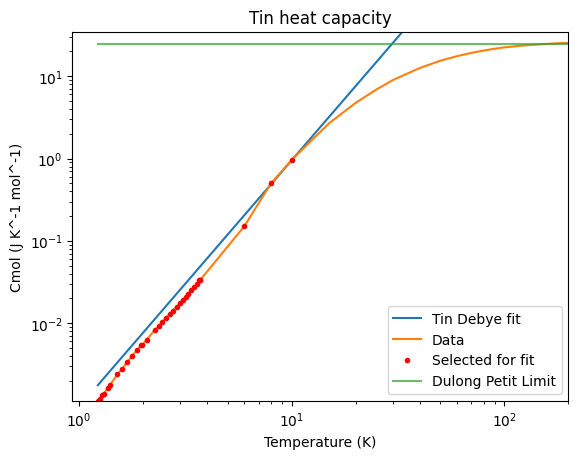

In [9]:
plt.figure()
plt.loglog(tinTemperature,debye(tinTemperature,poptLowTin),label="Tin Debye fit")
plt.loglog(tinTemperature,tinHeatCapacity,label="Data")
plt.loglog(tinLowTemperature,tinLowHeatCapacity, ".r",label = "Selected for fit")
plt.loglog(tinTemperature,list(DulongPetitLimit for x in range(len(tinTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.title("Tin heat capacity")
plt.xlim(0,200)
plt.ylim(tinHeatCapacity[0],DulongPetitLimit+10)
plt.legend()
print(poptLowTin)

In [10]:
'''
(d) Fit the data with the Einstein model at high temperatures (as shown in the right of figure 1) and extract
the Einstein temperature ΘE for the five materials. Show your fits on five separate plots with double
logarithmic axes
'''
#extract high temperature data
diamondHighTemperature = diamondTemperature[diamondHeatCapacity>1]
diamondHighHeatCapacity = diamondHeatCapacity[diamondHeatCapacity>1]
germaniumHighTemperature = germaniumTemperature[germaniumHeatCapacity>1]
germaniumHighHeatCapacity = germaniumHeatCapacity[germaniumHeatCapacity>1]
leadHighTemperature = leadTemperature[leadHeatCapacity>1]
leadHighHeatCapacity = leadHeatCapacity[leadHeatCapacity>1]
siliconHighTemperature = siliconTemperature[siliconHeatCapacity>1]
siliconHighHeatCapacity = siliconHeatCapacity[siliconHeatCapacity>1]
tinHighTemperature = tinTemperature[tinHeatCapacity>1]
tinHighHeatCapacity = tinHeatCapacity[tinHeatCapacity>1]


#curve fit to Einstein Model to get Etemps
poptHighDiamond,pcovHighDiamond = curveFit(EinsteinCaps,diamondHighTemperature,diamondHighHeatCapacity)
poptHighGermanium,pcovHighGermanium = curveFit(EinsteinCaps,germaniumHighTemperature,germaniumHighHeatCapacity)
poptHighLead,pcovHighLead = curveFit(EinsteinCaps,leadHighTemperature,leadHighHeatCapacity)
poptHighSilicon,pcovHighSilicon = curveFit(EinsteinCaps,siliconHighTemperature,siliconHighHeatCapacity)
poptHighTin,pcovHighTin = curveFit(EinsteinCaps,tinHighTemperature,tinHighHeatCapacity)

#plot for fun



[1305.47317163]


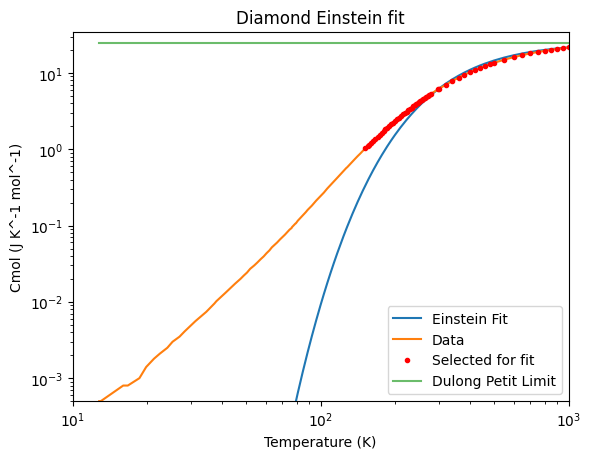

In [17]:
plt.title("Diamond Einstein fit")
plt.loglog(diamondTemperature,EinsteinCaps(diamondTemperature,poptHighDiamond),label="Einstein Fit")
plt.loglog(diamondTemperature,diamondHeatCapacity,label="Data")
plt.loglog(diamondHighTemperature,diamondHighHeatCapacity, ".r", label="Selected for fit")
plt.loglog(diamondTemperature,list(DulongPetitLimit for x in range(len(diamondTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlim(10,1000)
plt.ylim(diamondHeatCapacity[0],DulongPetitLimit+10)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.legend()
print(poptHighDiamond)

<ipython-input-12-bfcb04b02ca0>:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,200)


[253.01279287]


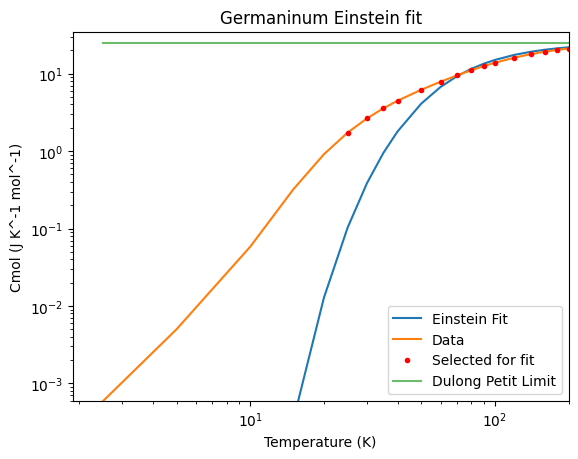

In [12]:
plt.title("Germaninum Einstein fit")
plt.loglog(germaniumTemperature,EinsteinCaps(germaniumTemperature,poptHighGermanium),label="Einstein Fit")
plt.loglog(germaniumTemperature,germaniumHeatCapacity,label="Data")
plt.loglog(germaniumHighTemperature,germaniumHighHeatCapacity,".r",label="Selected for fit")
plt.loglog(germaniumTemperature,list(DulongPetitLimit for x in range(len(germaniumTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlim(0,200)
plt.ylim(germaniumHeatCapacity[0],DulongPetitLimit+10)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.legend()
print(poptHighGermanium)

<ipython-input-13-706d859bb12a>:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,200)


[64.72035059]


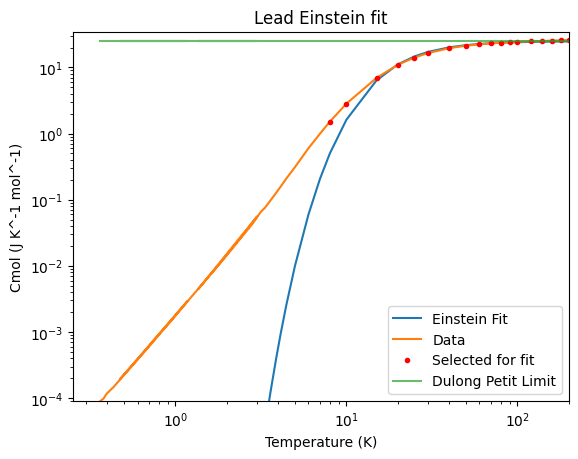

In [13]:
plt.title("Lead Einstein fit")
plt.loglog(leadTemperature,EinsteinCaps(leadTemperature,poptHighLead),label="Einstein Fit")
plt.loglog(leadTemperature,leadHeatCapacity,label="Data")
plt.loglog(leadHighTemperature,leadHighHeatCapacity, ".r",label="Selected for fit")
plt.loglog(leadTemperature,list(DulongPetitLimit for x in range(len(leadTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlim(0,200)
plt.ylim(leadHeatCapacity[0],DulongPetitLimit+10)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.legend()
print(poptHighLead)

[438.7007759]


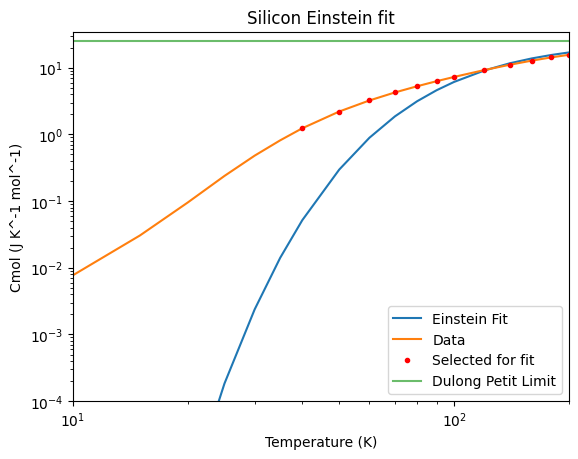

In [14]:
plt.title("Silicon Einstein fit")
plt.loglog(siliconTemperature,EinsteinCaps(siliconTemperature,poptHighSilicon),label="Einstein Fit")
plt.loglog(siliconTemperature,siliconHeatCapacity,label="Data")
plt.loglog(siliconHighTemperature,siliconHighHeatCapacity, ".r",label="Selected for fit")
plt.loglog(siliconTemperature,list(DulongPetitLimit for x in range(len(siliconTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlim(10,200)
plt.ylim(siliconHeatCapacity[0],DulongPetitLimit+10)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.legend()
print(poptHighSilicon)

<ipython-input-15-0de3ee573d19>:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,200)


[111.7531787]


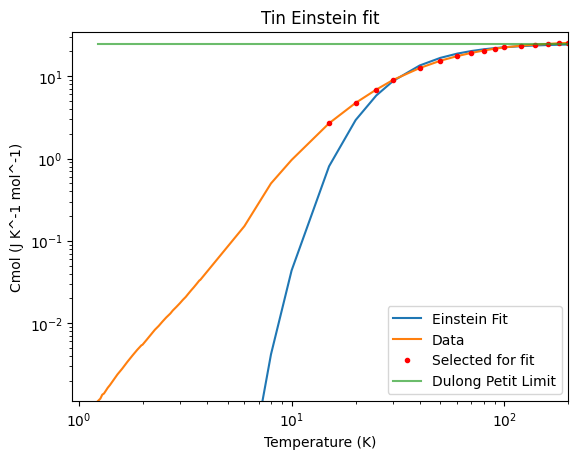

In [15]:
plt.title("Tin Einstein fit")
plt.loglog(tinTemperature,EinsteinCaps(tinTemperature,poptHighTin),label="Einstein Fit")
plt.loglog(tinTemperature,tinHeatCapacity,label="Data")
plt.loglog(tinHighTemperature,tinHighHeatCapacity, ".r",label="Selected for fit")
plt.loglog(tinTemperature,list(DulongPetitLimit for x in range(len(tinTemperature))),label="Dulong Petit Limit",alpha=0.7)
plt.xlim(0,200)
plt.ylim(tinHeatCapacity[0],DulongPetitLimit+10)
plt.xlabel("Temperature (K)")
plt.ylabel("Cmol (J K^-1 mol^-1)")
plt.legend()
print(poptHighTin)